# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
> In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 


> Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

> **The tools we have are:**
* color selection, 
* region of interest selection, 
* grayscaling, 
* Gaussian smoothing, 
* Canny Edge Detection and 
* Hough Tranform line detection.  


> **Explore and try other techniques that were not presented in the lesson. Our goal is piece together a pipeline**
* to detect the line segments in the image, 
* then average/extrapolate them and draw them onto the image for display (as below). 
* Once you have a working pipeline, try it out on the video stream below.

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
%matplotlib inline

In [2]:
# Polynomial Fitting Reference
# https://projects.skill-lync.com/projects/Curve-FItting-In-Python-Assignment-89826

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit as cf
from sklearn.metrics import mean_squared_error
from math import sqrt

# Defining Linear Polynomial
def linear(t, a, b):
    return a*t + b

# Defining Quadratic Polynomial
def quadratic(t, a, b, c):
    return a*pow(t, 2) + b*t + c

# Defining Cubic Polynomial
def cubic(t, a, b, c, d):
    return a*pow(t, 3) + b*pow(t, 2) + c*t + d

# Selecting Degree for Polynomial Curve Fitting
def select_degree(x, y, x_pred, y_actual):
    """Selects the degree of the polynomial that will fit the detected lane line points"""
    # Linear polynomial coefficients and covariance
    coefs_l, covar_l = cf(linear, x, y)
    
    # Getting y values for the predicted function
    y_pred_linear = linear(np.array(x_pred), *coefs_l)
    
    # Quadratic polynomial coefficients and covariance
    coefs_q, covar_q = cf(quadratic, x, y)
    
    # Getting y values for the predicted function
    y_pred_quadratic = quadratic(np.array(x_pred), *coefs_q)
    
    # Cubic polynomial coefficients and covariance
    coefs_c, covar_c = cf(cubic, x, y)

    # Getting y values for the predicted function
    y_pred_cubic = cubic(np.array(x_pred), *coefs_c)
    
    # Calculating Root Mean Square Error
    rmse_linear = sqrt(mean_squared_error(y_actual, y_pred_linear))
    rmse_quadratic = sqrt(mean_squared_error(y_actual, y_pred_quadratic))
    rmse_cubic = sqrt(mean_squared_error(y_actual, y_pred_cubic))
    
    # RMSE and Coefficients of different polynomial fits
    rmse = [rmse_linear, rmse_quadratic, rmse_cubic]
    coefs = [coefs_l, coefs_q, coefs_c]
    covar = [covar_l, covar_q, covar_c]
    # print(rmse)
    
    # Selecting Degree using Root Mean Square Error
    index_selct = np.argmin(np.array(rmse))
    degree = index_selct + 1
    return degree, coefs[index_selct]

def extrapolate_lines(x, y, img, color, thickness, side):
    """Lines are drawn on the image inplace (mutates the image)"""
    # Find lane parameters by polynomial fitting
    degree, z_coefs = select_degree(x[:-4], y[:-4], x[-4:], y[-4:])
    
    # Fitting the polynomial of estimated degree
#     degree = 1 # Hard coding the degree of the curve for now
    z_coefs = np.polyfit(x, y, degree)
    
    # Find the range of x values in x
    min_x, max_x = int(min(x)), int(max(x))
    
    # Find the range of y values in y
    min_y, max_y = int(min(y)), int(img.shape[1])
    
    # Get your new y coordinates from the coefficients of the above polynomial
    new_y = np.polyval(z_coefs, x)
    
    # Draw lane line curve on image
    if(side=="left" and degree == 1):
        max_x = int( (max_y - z_coefs[1])/z_coefs[0] )
        img = cv2.line(img, (min_x, min_y), (max_x, max_y), color, thickness)
    elif(side=="right" and degree == 1):
        min_x = int( (max_y - z_coefs[1])/z_coefs[0] )
        img = cv2.line(img, (min_x, max_y), (max_x, min_y), color, thickness)
    elif(side=="left" and degree == 2):
        max_x = int( (max_y - z_coefs[1])/z_coefs[0] )
        img = cv2.line(img, (min_x, min_y), (max_x, max_y), color, thickness)
    elif(side=="right" and degree == 2):
        min_x = int( (max_y - z_coefs[1])/z_coefs[0] )
        img = cv2.line(img, (min_x, max_y), (max_x, min_y), color, thickness)
    elif(side=="left" and degree == 3):
        max_x = int( (max_y - z_coefs[1])/z_coefs[0] )
        img = cv2.line(img, (min_x, min_y), (max_x, max_y), color, thickness)
    elif(side=="right" and degree == 3):
        min_x = int( (max_y - z_coefs[1])/z_coefs[0] )
        img = cv2.line(img, (min_x, max_y), (max_x, min_y), color, thickness)
    
    return img

In [3]:
# Helper functions for IMAGE PROCESSING using opencv
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness=4)
    
    # Separating right lane points from left lane points
    x_left, x_right = [], []
    y_left, y_right = [], []
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = (y2-y1)/(x2-x1)
            if(m > 0):
                x_left += [x1, x2]
                y_left += [y1, y2]
            else:
                x_right += [x1, x2]
                y_right += [y1, y2]
    
    # Extrapolating lane lines for perfect ego-vehicle manoeuvre
    lines_image = extrapolate_lines(x_left, y_left, img, color, thickness, "left")
    lines_image = extrapolate_lines(x_right, y_right, lines_image, color, thickness, "right")
    return lines_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1.0, γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Lane Finding Pipeline

> This pipeline detects lane lines from video or runs our solution on all test_images.


### TODO: 
* Build your pipeline that will draw lane lines on the test_images
* Save them to the test_images_output directory: `test_images_output`
* Experimentaion by tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters

In [4]:
def process_image(image):
    """Pipeline for Lane Line detection from an image input"""
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Converting the image to gray scale
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(image, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold) 

    # This time we are defining the region of the image defined by the polygon to mask
    imshape = image.shape
    vertices = np.array([[(-50,imshape[0]),(450, 330), (530, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180*60 # angular resolution in radians of the Hough grid
    threshold = 12   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 2   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image and draw lines on a blank image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image and draw the lines on the edge image
    color_edges = np.dstack((edges, edges, edges))
    # lines_edges = weighted_img(line_image, color_edges) # For lane lines with edges image
    color_edges = weighted_img(line_image, image)
    
#     return lines_edges
    return color_edges

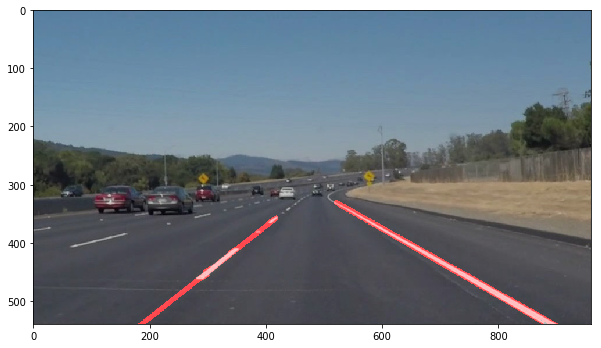

In [5]:
plt.figure(figsize=(10,10))
test_image = mpimg.imread("test_images/solidWhiteCurve.jpg")
lines_edges_del = process_image(test_image)
plt.imshow(lines_edges_del)

In [5]:
def process_clip(clip, output_clip):
    """Process a series of images for lane line detection and outputs a video clip with detected lane lines"""
    # reading a series of images (video) from test data
    clip = VideoFileClip("test_videos/solidYellowLeft.mp4")
    lines_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
    
    %time lines_clip.write_videofile(output_clip, audio=False)
    
    # Play the video inline after finding the video in your filesystem(should be in the same directory)
    display(HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(output_clip)))
    
    return output_clip

In [7]:
# Reading a series of images (video) from test data, displaying and saving it after road lines detection(clip1)
output_clip = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
output_clip1 = process_clip(clip1, output_clip)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:56<00:00, 11.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 15.5 s, sys: 2.05 s, total: 17.6 s
Wall time: 58.8 s


In [6]:
# Reading a series of images (video) from test data, displaying and saving it after road lines detection(clip2)
output_clip = 'test_videos_output/solidWhiteRight.mp4'
clip2 = VideoFileClip("test_videos/solidWhiteRight.mp4")
output_clip2 = process_clip(clip2, output_clip)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 681/682 [00:54<00:00, 12.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 14.8 s, sys: 2.31 s, total: 17.2 s
Wall time: 56.8 s


## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [7]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:53<00:00, 12.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 14.6 s, sys: 902 ms, total: 15.5 s
Wall time: 55.1 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

Satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [7]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))